# Compute syllable usage rate-of-change for all datasets

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from aging.plotting import figure, format_plots

In [3]:
format_plots()

In [1]:
def minmax(df):
    df = df - df.min()
    return df / df.max()

## V11

In [4]:
df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_raw_usage_matrix_v00.parquet')
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)
df = df[keep_syllables]

usage_order = df.quantile(0.9).sort_values(ascending=False).index
df = df[usage_order].astype('float32')

boot_df = []

n_boot = 100
boots = []
for i in range(n_boot):
    sampled = df.groupby('age').sample(frac=1, replace=True, random_state=i)
    avg_usage = sampled.groupby("age").mean()
    smoothed_avg_usage = avg_usage.rolling(
        5, min_periods=1, win_type="gaussian", center=True
    ).mean(std=2)
    abs_diff = smoothed_avg_usage.diff().abs()
    norm_diff = np.linalg.norm(abs_diff.to_numpy(), axis=1)
    # min-max normalize

    boots.append(
        pd.Series(norm_diff, index=abs_diff.index)
    )
_df = pd.DataFrame(boots).T.reset_index()
_df = _df.melt(id_vars="age")
_df['exp'] = 'ont_males'
boot_df.append(_df)

In [5]:
df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_raw_usage_matrix_v00.parquet')
df = df[keep_syllables]
df = df.query('age < 100')

boots = []
for i in range(n_boot):
    sampled = df.groupby('age').sample(frac=1, replace=True, random_state=i)
    avg_usage = sampled.groupby("age").mean()
    smoothed_avg_usage = avg_usage.rolling(
        5, min_periods=1, win_type="gaussian", center=True
    ).mean(std=2)
    abs_diff = smoothed_avg_usage.diff().abs()
    norm_diff = np.linalg.norm(abs_diff.to_numpy(), axis=1)
    # min-max normalize

    boots.append(
        pd.Series(norm_diff, index=abs_diff.index)
    )
_df = pd.DataFrame(boots).T.reset_index()
_df = _df.melt(id_vars="age")
_df['exp'] = 'ont_females'
boot_df.append(_df)

In [5]:
df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_males_raw_usage_matrix_v00.parquet')
df = df[keep_syllables]
df = df.query('age < 90')

usage_order = df.quantile(0.9).sort_values(ascending=False).index
df = df[usage_order].astype('float32')

df['age_binned'] = (df.index.get_level_values('age') * 7) // 30
df = df.set_index('age_binned', append=True)
df = df.groupby(['mouse', 'age_binned']).sample(n=1)

boots = []
for i in range(n_boot):
    sampled = df.groupby('age_binned').sample(frac=1, replace=True, random_state=i)
    avg_usage = sampled.groupby("age_binned").mean()
    smoothed_avg_usage = avg_usage.rolling(
        5, min_periods=1, win_type="gaussian", center=True
    ).mean(std=2)
    abs_diff = smoothed_avg_usage.diff().abs()
    norm_diff = np.linalg.norm(abs_diff.to_numpy(), axis=1)
    # min-max normalize

    boots.append(
        pd.Series(norm_diff, index=abs_diff.index)
    )
_df = pd.DataFrame(boots).T.reset_index()
_df = _df.melt(id_vars="age_binned")
_df['exp'] = 'long_males'
_df = _df.rename(columns={'age_binned': 'age'})
_df['age'] = (_df['age'] * 30) // 7
boot_df.append(_df)

In [6]:
df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_v2_females_raw_usage_matrix_v00.parquet')
df = df[keep_syllables]
df = df.query('age < 90')

df['age_binned'] = (df.index.get_level_values('age') * 7) // 30
df = df.set_index('age_binned', append=True)
df = df.groupby(['mouse', 'age_binned']).sample(n=1)

boots = []
for i in range(n_boot):
    sampled = df.groupby('age_binned').sample(frac=1, replace=True, random_state=i)
    avg_usage = sampled.groupby("age_binned").mean()
    smoothed_avg_usage = avg_usage.rolling(
        5, min_periods=1, win_type="gaussian", center=True
    ).mean(std=2)
    abs_diff = smoothed_avg_usage.diff().abs()
    norm_diff = np.linalg.norm(abs_diff.to_numpy(), axis=1)
    # min-max normalize

    boots.append(
        pd.Series(norm_diff, index=abs_diff.index)
    )
_df = pd.DataFrame(boots).T.reset_index()
_df = _df.melt(id_vars="age_binned")
_df['exp'] = 'long_v2_females'
_df = _df.rename(columns={'age_binned': 'age'})
_df['age'] = (_df['age'] * 30) // 7
boot_df.append(_df)

In [6]:
boot_df = pd.concat(boot_df)

In [7]:
boot_df

,age,variable,value,exp
0,4,0,NaN,ont_males
1,8,0,1.193293,ont_males
2,12,0,1.295393,ont_males
3,16,0,1.245220,ont_males
4,20,0,0.957867,ont_males
...,...,...,...,...
2095,72,99,0.691174,ont_females
2096,78,99,0.742507,ont_females
2097,80,99,0.957354,ont_females
2098,84,99,0.700093,ont_females


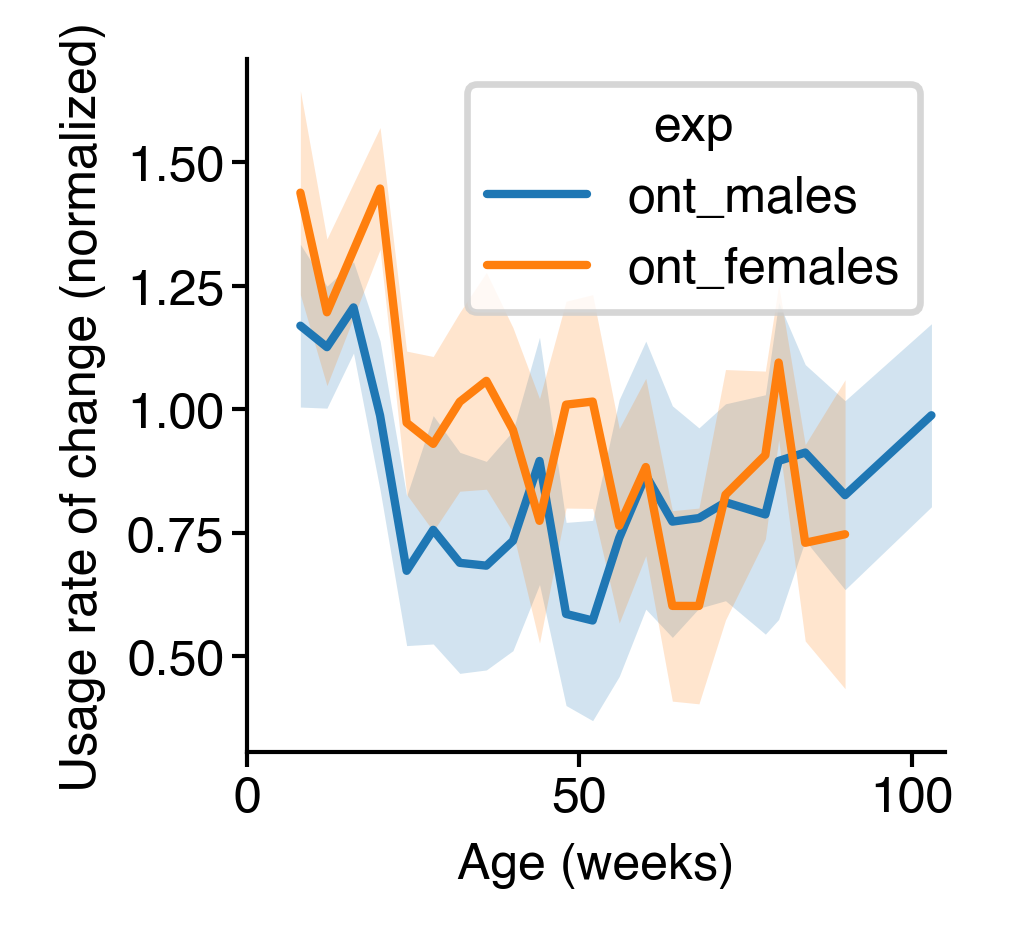

In [8]:
fig = figure(1.5, 1.5)
ax = sns.lineplot(
    data=boot_df.reset_index(),
    x="age",
    y="value",
    hue='exp',
    errorbar=("sd", 2),
    err_kws=dict(lw=0),
)
ax.set(xlim=(0, 105), ylabel="Usage rate of change (normalized)", xlabel="Age (weeks)")
sns.despine()

## V12

In [10]:
df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_12/ontogeny_males_raw_usage_matrix_v00.parquet')
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_12/to_keep_syllables_raw.txt', dtype=int)
df = df[keep_syllables]

usage_order = df.quantile(0.9).sort_values(ascending=False).index
df = df[usage_order].astype('float32')

boot_df = []

n_boot = 100
boots = []
for i in range(n_boot):
    sampled = df.groupby('age').sample(frac=1, replace=True, random_state=i)
    avg_usage = sampled.groupby("age").mean()
    smoothed_avg_usage = avg_usage.rolling(
        5, min_periods=1, win_type="gaussian", center=True
    ).mean(std=2)
    abs_diff = smoothed_avg_usage.diff().abs()
    norm_diff = np.linalg.norm(abs_diff.to_numpy(), axis=1)
    # min-max normalize

    boots.append(
        pd.Series(norm_diff, index=abs_diff.index)
    )
_df = pd.DataFrame(boots).T.reset_index()
_df = _df.melt(id_vars="age")
_df['exp'] = 'ont_males'
boot_df.append(_df)

In [11]:
df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_12/ontogeny_females_raw_usage_matrix_v00.parquet')
df = df[keep_syllables]
df = df.query('age < 100')

usage_order = df.quantile(0.9).sort_values(ascending=False).index
df = df[usage_order].astype('float32')

boots = []
for i in range(n_boot):
    sampled = df.groupby('age').sample(frac=1, replace=True, random_state=i)
    avg_usage = sampled.groupby("age").mean()
    smoothed_avg_usage = avg_usage.rolling(
        5, min_periods=1, win_type="gaussian", center=True
    ).mean(std=2)
    abs_diff = smoothed_avg_usage.diff().abs()
    norm_diff = np.linalg.norm(abs_diff.to_numpy(), axis=1)
    # min-max normalize

    boots.append(
        pd.Series(norm_diff, index=abs_diff.index)
    )
_df = pd.DataFrame(boots).T.reset_index()
_df = _df.melt(id_vars="age")
_df['exp'] = 'ont_females'
boot_df.append(_df)

In [12]:
df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_12/longtogeny_males_raw_usage_matrix_v00.parquet')
df = df[keep_syllables]
df = df.query('age < 90')

usage_order = df.quantile(0.9).sort_values(ascending=False).index
df = df[usage_order].astype('float32')

df['age_binned'] = (df.index.get_level_values('age') * 7) // 30
df = df.set_index('age_binned', append=True)
df = df.groupby(['mouse', 'age_binned']).sample(n=1)

boots = []
for i in range(n_boot):
    sampled = df.groupby('age_binned').sample(frac=1, replace=True, random_state=i)
    avg_usage = sampled.groupby("age_binned").mean()
    smoothed_avg_usage = avg_usage.rolling(
        5, min_periods=1, win_type="gaussian", center=True
    ).mean(std=2)
    abs_diff = smoothed_avg_usage.diff().abs()
    norm_diff = np.linalg.norm(abs_diff.to_numpy(), axis=1)
    # min-max normalize

    boots.append(
        pd.Series(norm_diff, index=abs_diff.index)
    )
_df = pd.DataFrame(boots).T.reset_index()
_df = _df.melt(id_vars="age_binned")
_df['exp'] = 'long_males'
_df = _df.rename(columns={'age_binned': 'age'})
_df['age'] = (_df['age'] * 30) // 7
boot_df.append(_df)

In [13]:
boot_df = pd.concat(boot_df)

In [14]:
boot_df

,age,variable,value,exp
0,4.0,0,NaN,ont_males
1,8.0,0,0.014767,ont_males
2,12.0,0,0.010749,ont_males
3,16.0,0,0.013502,ont_males
4,20.0,0,0.010990,ont_males
...,...,...,...,...
1595,51.0,99,0.009547,long_males
1596,55.0,99,0.010125,long_males
1597,60.0,99,0.008059,long_males
1598,64.0,99,0.010286,long_males


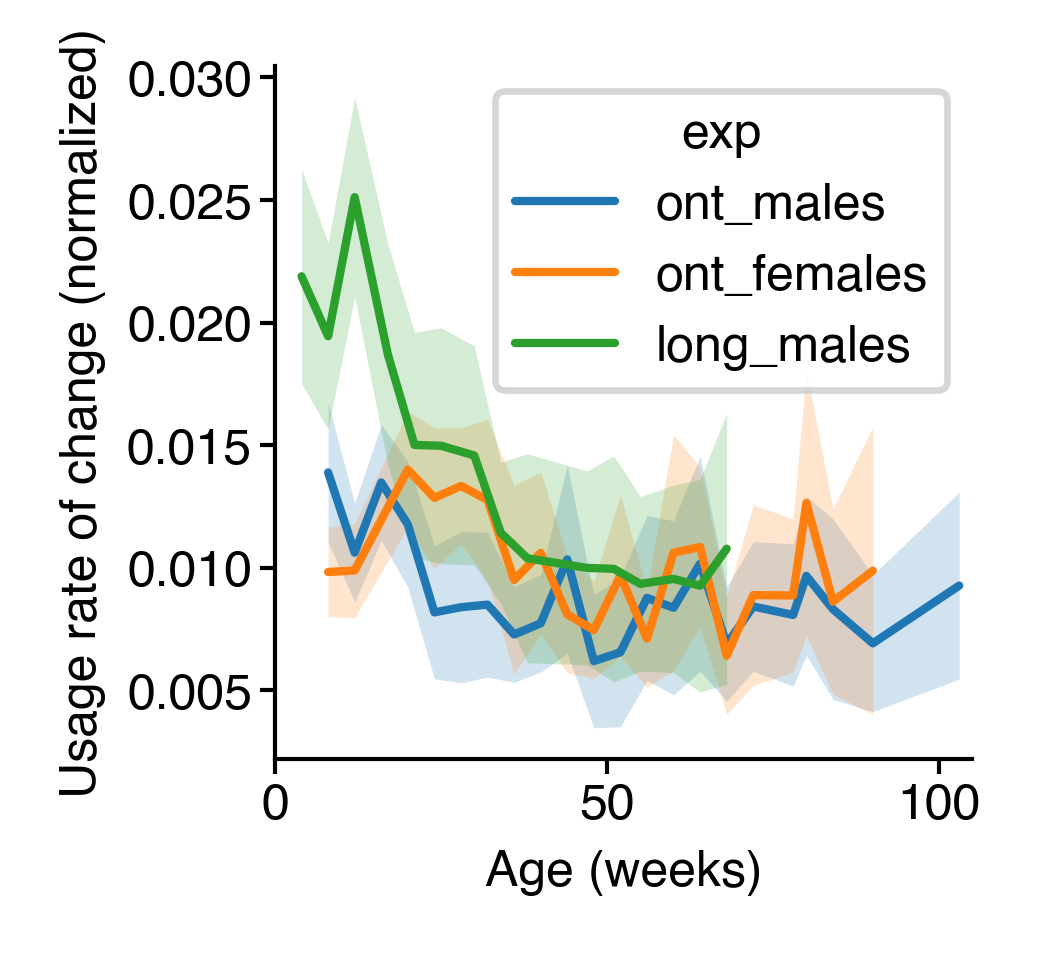

In [15]:
fig = figure(1.5, 1.5)
ax = sns.lineplot(
    data=boot_df.reset_index(),
    x="age",
    y="value",
    hue='exp',
    errorbar=("sd", 2),
    err_kws=dict(lw=0),
)
ax.set(xlim=(0, 105), ylabel="Usage rate of change (normalized)", xlabel="Age (weeks)")
sns.despine()